In [1]:
import numpy as np

In [2]:
!pip install qiskit==1.4.2
!pip install qiskit-aer==0.15
!pip install pylatexenc==2.10
!pip install qiskit_ibm_runtime==0.34.0
!pip install qiskit_algorithms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=07c22dc50e571838ba001ac71ad30024a80a3ae9b20cbc7c348527ac2f1c0462
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Statevector
from qiskit_aer.primitives import SamplerV2
from qiskit.providers.basic_provider import BasicProvider
from qiskit.circuit.library import UnitaryGate
from qiskit.synthesis import OneQubitEulerDecomposer

In [4]:
def M1(alpha: float, beta: complex):
    return np.array(
        [
            [alpha, -np.conj(beta)],
            [beta, alpha]
        ]
    )

def adjoint(matrix: np.ndarray):
    return np.transpose(np.conjugate(matrix))

def n(z: complex): return z * np.conj(z)

In [5]:
def prepare_state(qc: QuantumCircuit, a: complex, b: complex, c: complex, d: complex):
    """Returns a qc that prepares the given two qubit states (where the four complex amplitudes are in their canonical order)."""

    # Normalizataion step
    norm = n(a) + n(b) + n(c) + n(d)
    if norm != 1:
        m = np.sqrt(norm)
        a, b, c, d = a / m, b / m, c / m, d / m

    # Removing global phase
    angle = np.angle(a)
    gp = np.exp(1j * angle)
    a, b, c, d = a / gp, b / gp, c / gp, d / gp

    theta = 2 * np.atan(np.sqrt((n(c) + n(d)) / (n(a) + n(b))))
    theta = np.abs(theta)
    qc.ry(theta, 0)
    decomposer = OneQubitEulerDecomposer('U')
    theta1, phi1, lam1 = decomposer.angles(M1(a, b))
    qc.u(theta1, phi1, lam1, 1)

    theta2, phi2, lam2 = decomposer.angles(M1(c, d) @ adjoint(M1(a, b)))

    qc.cu(theta2, phi2, lam2, 0, 0, 1)

    qc.global_phase = angle
    return


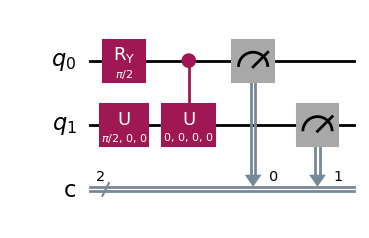

In [6]:
# Example: Preparing an equal superposition

qc = QuantumCircuit(2, 2)
prepare_state(qc, 0.5, 0.5, 0.5, 0.5)

for i in range(2): qc.measure(i, i)

qc.draw(output="mpl")


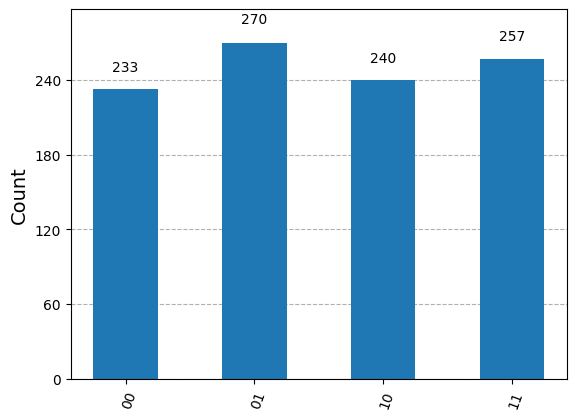

In [7]:
sampler = SamplerV2()
job = sampler.run([qc], shots=1000)
result = job.result()
counts = result[0].data.c.get_counts()
plot_histogram(counts)

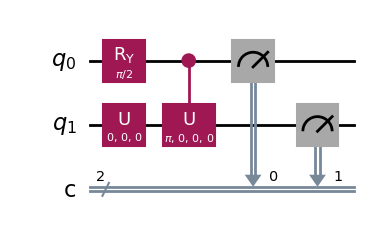

In [8]:
# Example: Preparing a Bell State

qc2 = QuantumCircuit(2, 2)
prepare_state(qc2, 0.5, 0, 0, 0.5)

for i in range(2): qc2.measure(i, i)

qc2.draw(output = "mpl")

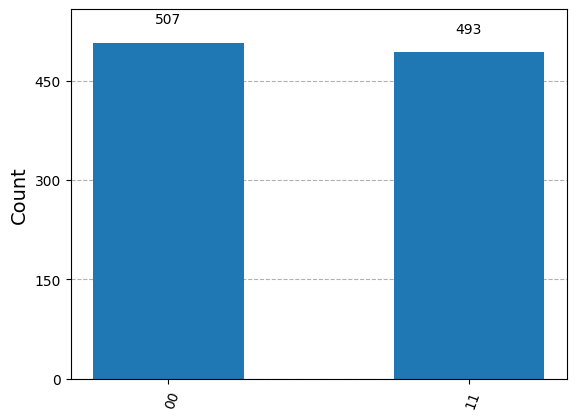

In [9]:
sampler = SamplerV2()
job = sampler.run([qc2], shots=1000)
result = job.result()
counts = result[0].data.c.get_counts()
plot_histogram(counts)

In [10]:
!python -m unittest discover -s . -p 'testing.py'


----------------------------------------------------------------------
Ran 0 tests in 0.000s

NO TESTS RAN
